In [257]:
"""
TODO:
Create bans features (e.g. num mid bans, num top bans, num flex bans)
    - make the value continuous with percentage of the bans to accomodate the increased number of bans
    e.g. 2/3 mid bans is assigned "0.66"; 1/5 mid bans is assigned "0.2"
    - to decide if <role> ban vs flex ban
        1. groupby tournament
        2. count number of times the champion for each lane
        3. if the count is > 0 for 2 or more lanes, automatically flex

Create function to easily make the bar graphs.
"""

'\nTODO:\nCreate bans features (e.g. num mid bans, num top bans, num flex bans)\n    - make the value continuous with percentage of the bans to accomodate the increased number of bans\n    e.g. 2/3 mid bans is assigned "0.66"; 1/5 mid bans is assigned "0.2"\n    - to decide if <role> ban vs flex ban\n        1. groupby tournament\n        2. count number of times the champion for each lane\n        3. if the count is > 0 for 2 or more lanes, automatically flex\n\nCreate function to easily make the bar graphs.\n'

In [258]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

plt.style.use("seaborn-whitegrid")

# Helper Functions

In [259]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    # mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# EDA

In [260]:
original = pd.read_csv("merged9.csv")
data = original.copy()
data_no_encode = original.copy()
target = data.pop("W/L")

In [261]:
print(original.shape)
print(original['W/L'].value_counts()[1])

(987, 65)
325


In [262]:
# If you want to balance the target
# load = pd.read_csv("merged9.csv")
num_wins = data_no_encode['W/L'].value_counts()[0]
num_losses = data_no_encode['W/L'].value_counts()[1]
data_no_encode['W/L'].value_counts()

data = data_no_encode[data_no_encode['W/L'] == "Win"].sample(num_losses)
data = pd.concat([data, data_no_encode[data_no_encode['W/L'] == "Loss"]])
data.shape

(650, 65)

In [263]:
# Need to fix Spell column
original.Spells.unique()

array(['Ignite,Flash', 'Exhaust,Flash', 'Barrier,Flash', 'Ghost,Flash',
       'Flash,Heal', 'Heal,Flash', 'Cleanse,Flash', 'Smite,Flash',
       'Teleport,Flash', 'Teleport,Ghost', 'Heal,FlashArcane Comet',
       'Heal,FlashSummon Aery', 'Cleanse,FlashUnsealed Spellbook',
       'Heal,FlashUnsealed Spellbook', 'Cleanse,FlashArcane Comet',
       'Teleport,FlashArcane Comet', 'Teleport,FlashFleet Footwork',
       'Ignite,FlashUnsealed Spellbook',
       'Teleport,FlashUnsealed Spellbook', 'Teleport,FlashAftershock',
       'Teleport,FlashElectrocute', 'Teleport,FlashKleptomancy',
       'Barrier,FlashUnsealed Spellbook', 'Ghost,FlashPhase Rush',
       'Cleanse,FlashSummon Aery', 'Ignite,FlashSummon Aery',
       'Ignite,FlashConqueror', 'Teleport,FlashSummon Aery',
       'Heal,FlashGuardian', 'Teleport,FlashPhase Rush',
       'Barrier,FlashConqueror', 'Ghost,FlashConqueror',
       'Heal,ExhaustGuardian', 'Heal,FlashPhase Rush',
       'Cleanse,FlashConqueror', 'Teleport,FlashConq

In [264]:
# For EDA that requires the target
data_target_encoded = data.copy()
data.pop('W/L')
win_loss_encoded = []
spell_d_key, spell_f_key = [], []
for _, row in data_target_encoded.iterrows():
    # Encode win_loss
    if row["W/L"] == "Win":
        win_loss_encoded.append(1)
    else:
        win_loss_encoded.append(0)

    # Fix Spell column
    spells = row["Spells"].split(',')
    spell_1, spell_2 = spells[0], spells[1]
    # Spell 2 could be "Flash<Keystone> or Exhaust<Keystone>"
    if 'Flash' in spell_2:
        spell_2 = 'Flash'
    elif 'Exhaust' in spell_2:
        spell_2 = 'Exhaust'
    else:
        print(f"spell_2 = {spell_2}")
    spell_d_key.append(spell_1.lower())
    spell_f_key.append(spell_2.lower())

data_target_encoded["W/L"] = win_loss_encoded
data["spell_1"] = spell_d_key
data["spell_2"] = spell_f_key
data_target_encoded["spell_1"] = spell_d_key
data_target_encoded["spell_2"] = spell_f_key
# data_no_encode["spell_1"] = spell_d_key
# data_no_encode["spell_2"] = spell_f_key

spell_2 = Heal


In [265]:
# # Look at item build of particular champions
# data[data.Champion == "Kog'Maw"]["Items"]

In [266]:
# Drop columns that will not be available at the moment of prediction
unavailable_cols = ['Game_Length', 'Kills', 'Deaths', 'Assists', 'KDA', 'CS', 'Delta_CS', 'Items',]
data = data.drop(columns=unavailable_cols)

In [267]:
# Drop unnecessary columns
unnecessary_cols = [
    'Date', 'Date_parsed', 'date', 'Tournament', 'winner',
    'teammate_mid_ign', 'blue_side_picks', 'red_side_picks', 'bans', 'blue_side_bans',
    'red_side_bans', 'red_side_roster', 'blue_side_roster', 'blue_side_team', 'red_side_team',
    'teammate_mid_champion', 'Vs_Champion'
]
data = data.drop(columns=unnecessary_cols)

In [268]:
# Drop columns that have null values
missing_values_count = data.isnull().sum()
cols_with_missing_values = [col for col, num_missing in missing_values_count.iteritems() if num_missing > 0]
print(cols_with_missing_values)
data = data.drop(columns=cols_with_missing_values)

[]


In [269]:
# Encode categorical columns through factorize()
## Did not use OrdinalScaler because MI function does not like the dtype it returns
for col in data.select_dtypes("object"):
    data[col], label = data[col].factorize()

# --------------------------
# If I ever want to use OrdinalScaler
## Get Categorical Columns
# categorical_cols = (data.dtypes == 'object')
# categorical_cols = list(categorical_cols[categorical_cols].index)
## Encode categorical columns through OrdinalEncoder. note - this will make the column dtype == float which is not compatible with MI scores
# ordinal_encoder = OrdinalEncoder()
# data[categorical_cols] = ordinal_encoder.fit_transform(data[categorical_cols])  # I believe this is Data Leakage because the data has not been separated from train/valid sets

In [270]:
print(label)

Index(['flash', 'heal', 'exhaust'], dtype='object')


In [271]:
# Practice target encoding
## This essentially gets the win percentage against each region
data["teams_region_encoded"] = data_target_encoded.groupby("teams_region")["W/L"].transform("mean")

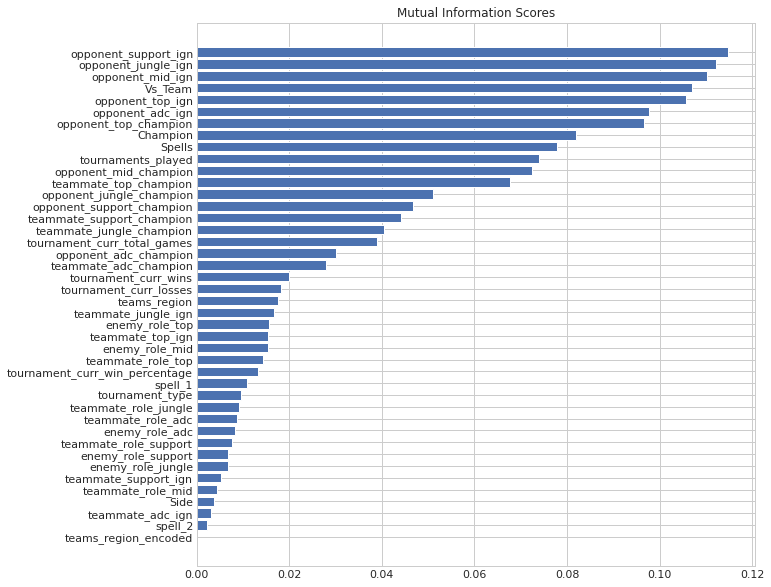

In [272]:
discrete_features = data.dtypes == int
mi_scores = make_mi_scores(data, data_target_encoded["W/L"], discrete_features)
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores)

In [273]:
# # Get list of categorical variables
# s = (data_target_encoded.dtypes == 'object')
# object_cols = list(s[s].index)

# print("Categorical variables:")
# print(object_cols)

# object_cols = ["teammate_role_top",  "teammate_role_jungle", "teammate_role_mid",  "teammate_role_adc",  "teammate_role_support"]
# object_cols = ["spell_1", "teammate_role_mid"]
# object_cols = ["tournament_type", "teams_region"]

object_cols = ["opponent_top_ign", "opponent_jungle_ign", "opponent_mid_ign", "opponent_adc_ign", "opponent_support_ign"]
# ==>
# PC17     0.098054
# PC203    0.087453
# PC255    0.087297
# PC18     0.087098
# PC11     0.086278 ...
# object_cols = ["teammate_top_ign", "teammate_jungle_ign", "teammate_adc_ign", "teammate_support_ign"]
# object_cols = ["Side", "teammate_role_mid"]

# object_cols = ["spell_1", "teammate_role_mid", "enemy_role_mid", "opponent_mid_ign"]
# ==>
# PC62     0.056869
# PC68     0.054939
# PC76     0.051848
# PC51     0.046653
# PC35     0.045671

In [274]:
# block c/p from Kaggle. seems like there could be a smoother way to do all this
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(data_target_encoded[object_cols]))
OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)
num_oh_cols = len(OH_cols.columns)

# One-hot encoding removed index; put it back
OH_cols.index = data_target_encoded.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = data_target_encoded.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_cols], axis=1)

OH_X.head()

,Date,Tournament,W/L,Side,Vs_Team,Game_Length,Champion,Vs_Champion,Kills,Deaths,...,opponent_support_ign_Xpecial,opponent_support_ign_YellOwStaR,opponent_support_ign_Zero (Yoon Kyung-sup),opponent_support_ign_aphromoo,opponent_support_ign_hachani,opponent_support_ign_huhi,opponent_support_ign_kaSing,opponent_support_ign_key,opponent_support_ign_mithy,opponent_support_ign_yuyanjia
585,2018-06-09 07:06:00,"Asia,Asian Games 2018 Q - East",1,Blue,Japan (National Team),23:36,Taric,Vladimir,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
518,2017-11-29 10:24:00,"Korea,KeSPA Cup 2017",1,Red,Griffin (Korean Team),47:55,Azir,Xerath,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
611,2018-07-13 11:17:00,"Korea,LCK 2018 Summer",1,Red,Hanwha Life Esports,33:06,Galio,Swain,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791,2020-02-22 10:34:00,"Korea,LCK 2020 Spring",1,Red,APK Prince,31:37,Rumble,Syndra,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,2017-08-06 08:39:00,"Korea,LCK 2017 Summer",1,Red,bbq Olivers,39:35,Lucian,Syndra,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
# PCA with OneHotEncoder
features = OH_X.columns[(num_oh_cols * -1):]
# features = list(features) + ["tournament_curr_win_percentage"]

pca_test_X = OH_X.copy()
pca_test_y = pca_test_X.pop("W/L")
pca_test_X = pca_test_X.loc[:, features]

# Standardize
pca_test_X_scaled = (pca_test_X - pca_test_X.mean(axis=0)) / pca_test_X.std(axis=0)

pca = PCA()
X_pca = pca.fit_transform(pca_test_X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

In [276]:
# PCA w/o OneHotEncoding (i.e. with Ordinal Encoding)
# features = OH_X.columns[(num_oh_cols * -1):]
# features = list(features) + ["tournament_curr_win_percentage"]
features = object_cols

pca_o_test_X = data.copy()
pca_o_test_y = target
pca_o_test_X = pca_o_test_X.loc[:, features]

# Standardize
pca_o_test_X_scaled = (pca_o_test_X - pca_o_test_X.mean(axis=0)) / pca_o_test_X.std(axis=0)

pca_o = PCA()
X_pca_o = pca_o.fit_transform(pca_o_test_X_scaled)

# Convert to dataframe
component_names_o = [f"PC{i+1}" for i in range(X_pca_o.shape[1])]
X_pca_o = pd.DataFrame(X_pca_o, columns=component_names_o)

In [277]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=pca_test_X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC447,PC448,PC449,PC450,PC451,PC452,PC453,PC454,PC455,PC456
opponent_top_ign_369,0.000285,0.000624,0.000401,0.000769,0.000892,9.012402e-19,-9.286325e-16,-8.929775e-20,0.000000e+00,0.054751,...,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.832084
opponent_top_ign_957,-0.007553,0.001171,0.000415,-0.001292,-0.001326,-1.536955e-16,1.604274e-15,4.550207e-17,4.939925e-17,0.040348,...,0.002752,-0.005532,0.026089,0.006374,-0.041149,-0.015242,0.010326,-0.009834,-0.014239,-0.000454
opponent_top_ign_ADD,-0.006773,0.001962,0.000917,-0.000716,-0.000862,-1.910244e-16,1.268295e-15,3.463779e-16,-2.281521e-16,-0.027592,...,-0.020075,0.060570,0.016433,-0.002800,0.036978,0.025379,0.003832,0.008245,-0.003871,-0.002555
opponent_top_ign_Acorn,-0.010314,0.000259,-0.000250,-0.002819,-0.002925,8.969234e-17,3.213287e-15,2.417938e-17,-8.350839e-17,0.007186,...,0.015659,0.007814,-0.021893,0.026551,0.007038,0.009704,0.006991,-0.060088,-0.008547,-0.001352
opponent_top_ign_Alphari,-0.002913,-0.001189,-0.000829,-0.001573,-0.001563,6.056787e-17,1.660458e-15,1.288861e-16,1.666496e-16,-0.018265,...,-0.015123,0.006625,-0.018564,-0.002389,-0.007416,-0.005110,0.015523,-0.020329,0.005433,-0.000815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opponent_support_ign_huhi,-0.005101,0.000631,0.000179,-0.001090,-0.001165,9.887924e-17,1.710437e-15,-2.151057e-16,3.816392e-17,0.002286,...,-0.196005,0.030921,0.039579,-0.010323,-0.043620,-0.162870,-0.006486,-0.061559,0.069390,-0.000649
opponent_support_ign_kaSing,0.020511,-0.016704,-0.009213,-0.003765,-0.002674,-4.228388e-16,1.718677e-15,-1.034763e-15,-4.145989e-16,0.000883,...,-0.080292,-0.015521,-0.032443,-0.001703,-0.019528,0.014516,0.012598,0.001961,-0.017627,-0.000048
opponent_support_ign_key,-0.007605,0.000533,0.000020,-0.001912,-0.002032,3.573530e-16,2.222181e-15,1.335737e-16,3.035766e-16,-0.015179,...,0.008635,0.003947,0.008622,-0.000600,-0.006310,-0.012197,-0.013914,-0.014250,-0.002402,-0.000329
opponent_support_ign_mithy,0.030341,-0.027432,-0.015268,-0.007304,-0.005614,-7.287194e-16,4.491497e-15,-1.011723e-15,-5.986422e-16,-0.015268,...,0.024885,0.010005,0.011246,-0.043062,-0.008209,-0.030469,0.004741,-0.048520,0.003026,-0.000960


In [278]:
loadings_o = pd.DataFrame(
    pca_o.components_.T,  # transpose the matrix of loadings
    columns=component_names_o,  # so the columns are the principal components
    index=pca_o_test_X.columns,  # and the rows are the original features
)
loadings_o

,PC1,PC2,PC3,PC4,PC5
opponent_top_ign,0.448812,-0.561349,0.036913,0.500611,0.481125
opponent_jungle_ign,0.442212,0.552572,-0.506412,-0.180140,0.458485
opponent_mid_ign,0.475413,0.253998,-0.091585,0.506286,-0.666899
opponent_adc_ign,0.427740,0.251943,0.824802,-0.253353,0.095274
opponent_support_ign,0.440496,-0.501559,-0.231298,-0.629623,-0.323232


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

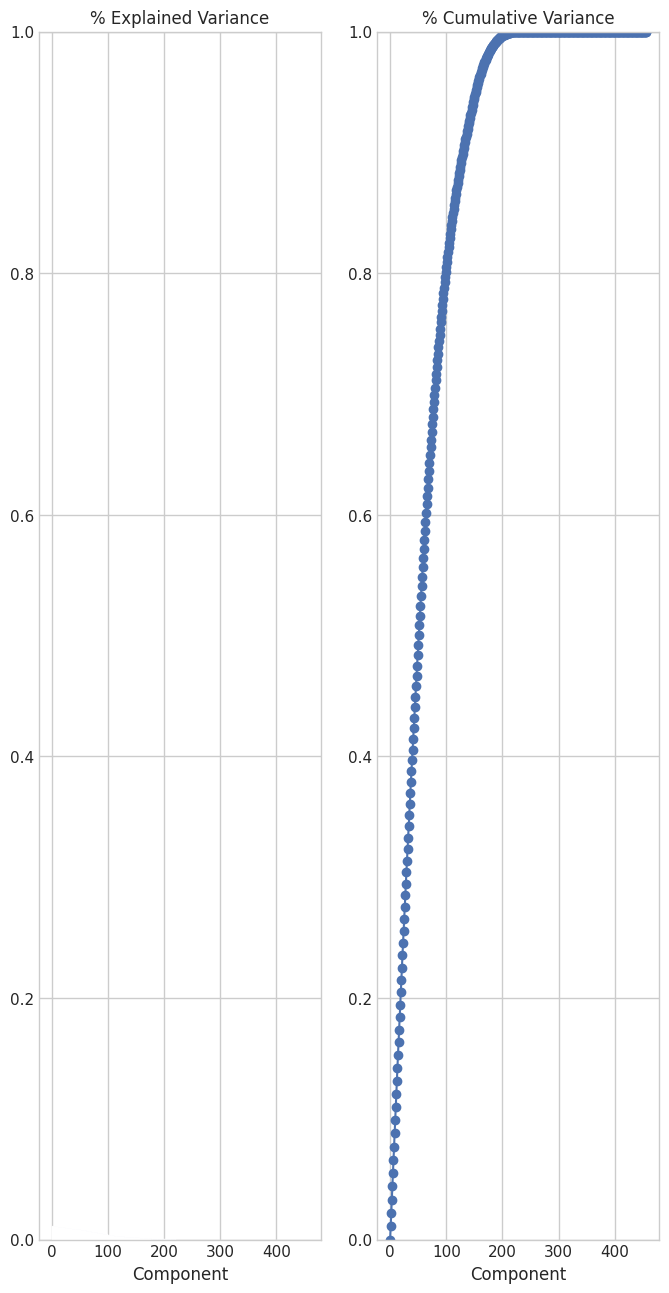

In [279]:
plot_variance(pca)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

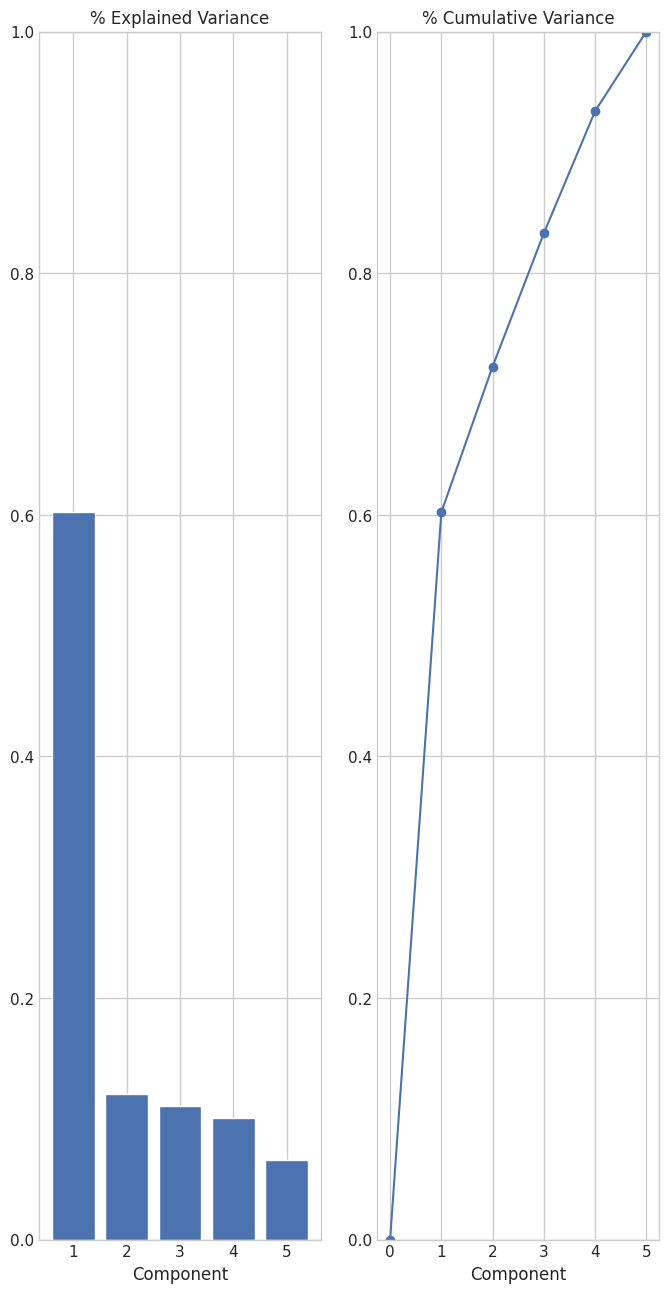

In [280]:
plot_variance(pca_o)

In [281]:
mi_scores = make_mi_scores(X_pca, data_target_encoded["W/L"], discrete_features=False)
mi_scores

PC192    0.085964
PC109    0.078166
PC51     0.077110
PC223    0.076306
PC201    0.075634
           ...   
PC336    0.000000
PC339    0.000000
PC344    0.000000
PC345    0.000000
PC456    0.000000
Name: MI Scores, Length: 456, dtype: float64

In [282]:
mi_scores_o = make_mi_scores(X_pca_o, data_target_encoded["W/L"], discrete_features=False)
mi_scores_o

PC2    0.052070
PC5    0.037772
PC1    0.024927
PC3    0.024668
PC4    0.022026
Name: MI Scores, dtype: float64

In [283]:
highest_pca_mi = mi_scores.index[0]
# loadings.PC16.sort_values(ascending=False)
# loadings.PC13.sort_values(ascending=False)
idx = X_pca[highest_pca_mi].sort_values(ascending=False).index
cols = object_cols + ["Champion", "W/L"]
print(data_target_encoded.loc[idx, cols].head(50))

KeyError: '[482, 11, 569, 209, 411, 355, 435, 192, 119, 248, 72, 530, 25, 364, 1, 156, 495, 523, 306, 527, 255, 492, 498, 165, 414, 377, 503, 63, 118, 629, 607, 645, 44, 36, 227, 423, 497, 628, 623, 308, 599, 280, 340, 601, 66, 61, 649, 384, 217, 138, 97, 546, 39, 292, 407, 112, 419, 362, 320, 32, 379, 262, 325, 60, 438, 57, 166, 225, 126, 424, 299, 136, 3, 20, 144, 285, 141, 190, 397, 291, 588, 241, 184, 566, 223, 277, 93, 193, 251, 167, 460, 311, 135, 23, 161, 41, 169, 27, 120, 302, 100, 197, 261, 369, 399, 77, 328, 326, 194, 333, 634, 83, 371, 266, 357, 284, 351, 418, 348, 636, 635, 70, 249, 263, 146, 51, 5, 461, 462, 71, 584, 75, 479, 491, 490, 502, 50, 69, 157, 150, 226, 454, 222, 12, 417, 232, 272, 205, 338, 59, 62, 283, 164, 127, 28, 591, 137, 621, 109, 293, 550, 317, 387, 298, 410, 177, 148, 214, 392, 80, 139, 84, 240, 547, 485, 441, 452, 459, 451, 85, 581, 586, 265, 310, 576, 7, 447, 448, 426, 427, 102, 281, 575, 196, 391, 421, 382, 383, 396, 14, 453, 429, 121, 10, 45, 633, 163, 73, 486, 318, 230, 534, 529, 210, 551, 250, 558, 506, 279, 296, 37, 79, 178, 521, 42, 626, 19, 82, 207, 220] not in index'

In [284]:
highest_pca_mi = mi_scores_o.index[0]
# loadings.PC16.sort_values(ascending=False)
# loadings.PC13.sort_values(ascending=False)
idx = X_pca_o[highest_pca_mi].sort_values(ascending=False).index
cols = object_cols + ["Champion", "W/L"]
print(data_target_encoded.loc[idx, cols].head(50))

KeyError: '[291, 397, 369, 261, 419, 146, 340, 410, 298, 387, 379, 377, 299, 424, 126, 462, 461, 156, 205, 338, 280, 591, 177, 214, 392, 364, 383, 391, 421, 396, 382, 318, 486, 93, 80, 148, 248, 628, 623, 84, 139, 42, 626, 119, 45, 435, 112, 407, 479, 490, 491, 220, 141, 285, 69, 164, 102, 281, 569, 157, 240, 547, 296, 37, 355, 36, 423, 497, 227, 534, 230, 529, 226, 502, 39, 292, 546, 97, 495, 503, 251, 127, 14, 453, 10, 429, 121, 521, 284, 351, 357, 492, 498, 165, 506, 192, 302, 311, 249, 263, 207, 82, 19, 1, 28, 3, 485, 222, 12, 454, 5, 71, 7, 11, 482, 161, 23, 308, 599, 62, 59, 283, 27, 169, 135, 250, 210, 551, 558, 51, 279, 399, 77, 418, 193, 79, 32, 460, 167, 197, 566, 223, 72, 530, 25, 120, 277, 441, 85, 451, 452, 459, 217, 384, 20, 447, 448, 426, 427, 184, 61, 194, 362, 635, 70, 636, 150, 50, 581, 306, 527, 255, 523, 209, 317, 262, 196, 75, 584, 629, 118, 63, 44, 607, 645, 575, 163, 73, 136, 633, 232, 417, 272, 438, 57, 60, 414, 333, 190, 649, 41, 225, 83, 634, 178, 310, 265, 576, 586, 293, 109, 550, 411, 266, 137, 621, 66, 326, 328, 144, 138, 601, 325, 100, 371, 588, 348, 166, 320, 241] not in index'

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Japan'),
  Text(1, 0, 'Korea'),
  Text(2, 0, 'China'),
  Text(3, 0, 'Europe'),
  Text(4, 0, 'LMS'),
  Text(5, 0, 'North America'),
  Text(6, 0, 'Vietnam'),
  Text(7, 0, 'PCS'),
  Text(8, 0, 'CIS'),
  Text(9, 0, 'International')])

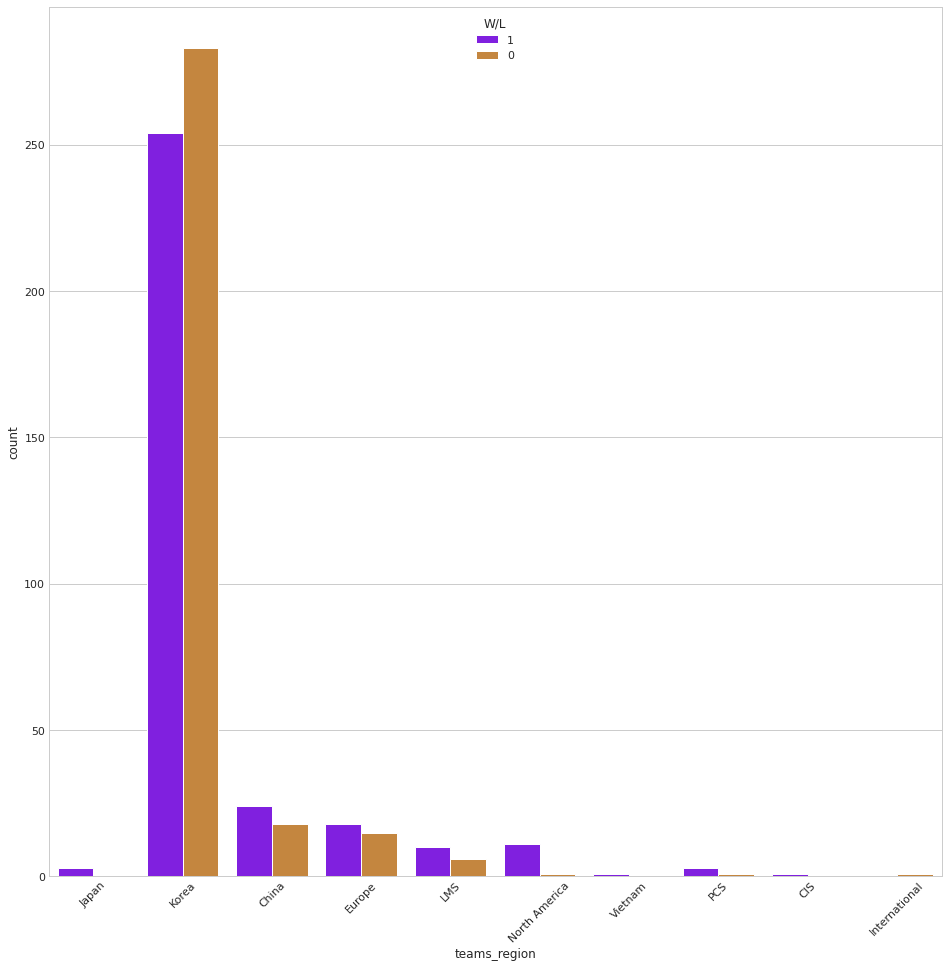

In [285]:
# sns.countplot(data=data_target_encoded, x='teams_region',palette=["#8000ff","#da8829"], hue='W/L')
catp = sns.countplot(data=data_target_encoded, x='teams_region',palette=["#8000ff","#da8829"], hue='W/L', hue_order=[1, 0])
plt.xticks(rotation=45)

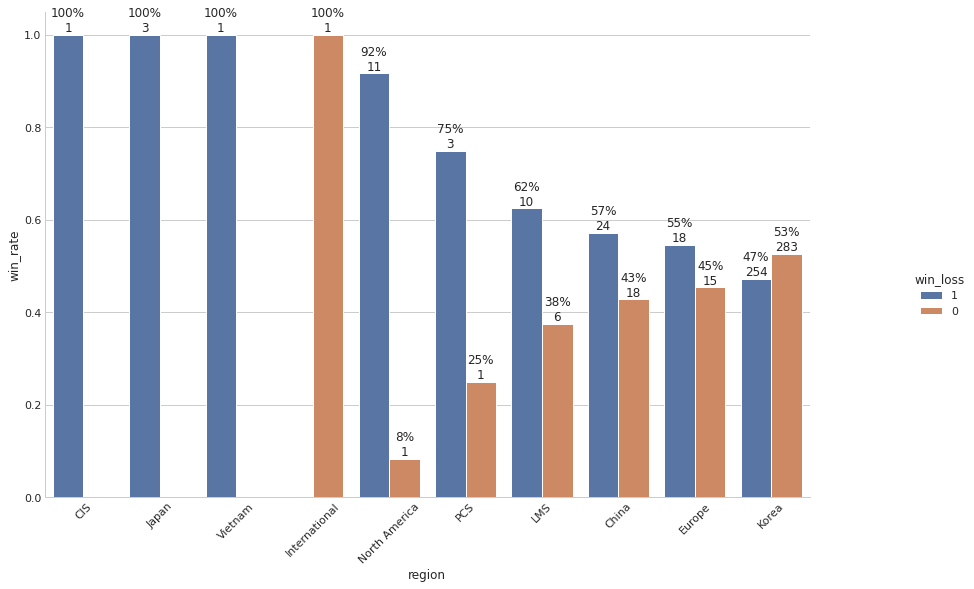

In [286]:
# TODO: fix total games number that is on top of each bar. utilize v.get_height * num of games
foo = data_target_encoded.groupby("teams_region")['W/L'].value_counts(normalize=True)
# foo = copy.groupby("teammate_role_mid")['W/L'].value_counts(normalize=True).unstack(fill_value=0)
frame = {}
region, win_loss, rate = [], [], []
for r, test in foo.iteritems():
    region.append(r[0])
    win_loss.append(r[1])
    rate.append(test)

result = pd.DataFrame()
result['region'] = region
result['win_loss'] = win_loss
result['win_rate'] = rate
result = result.sort_values(['win_rate', 'win_loss'], ascending=False)

cnt = data_target_encoded['teams_region'].value_counts()
# lst = []
# for region in result['region'].iteritems():
#     if region not in lst:
#         cnt = data_target_encoded['teams_region'].value_counts()
#         lst.append

catp = sns.catplot(x="region", y="win_rate", hue="win_loss", data=result, kind="bar", hue_order=[1, 0])
plt.xticks(rotation=45)
catp.fig.set_size_inches(15, 8)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = catp.facet_axis(0, 0)
# iterate through the axes containers

i = 0
for c in ax.containers:
    labels = []
    for i, v in enumerate(c):
        perc = f"{v.get_height() * 100:.0f}"
        region = result.iloc[i].region
        total_games = f"{cnt.get(key=region)}"
        num_games = int(total_games) * float(v.get_height())

        top_of_bar = f"{perc}%\n{num_games:.0f}"
        labels.append(top_of_bar)
    # labels = [f'{(v.get_height()) * 100:.0f}%\n{cnt.iloc[i]}' for v,i in enumerate(c)]
    ax.bar_label(c, labels=labels, label_type='edge')

In [287]:
data_no_encode['tournament_type'].unique()

array(['Regular Season', 'Playoffs', 'Gauntlet', 'International',
       'Low Stakes', 'No Stakes'], dtype=object)

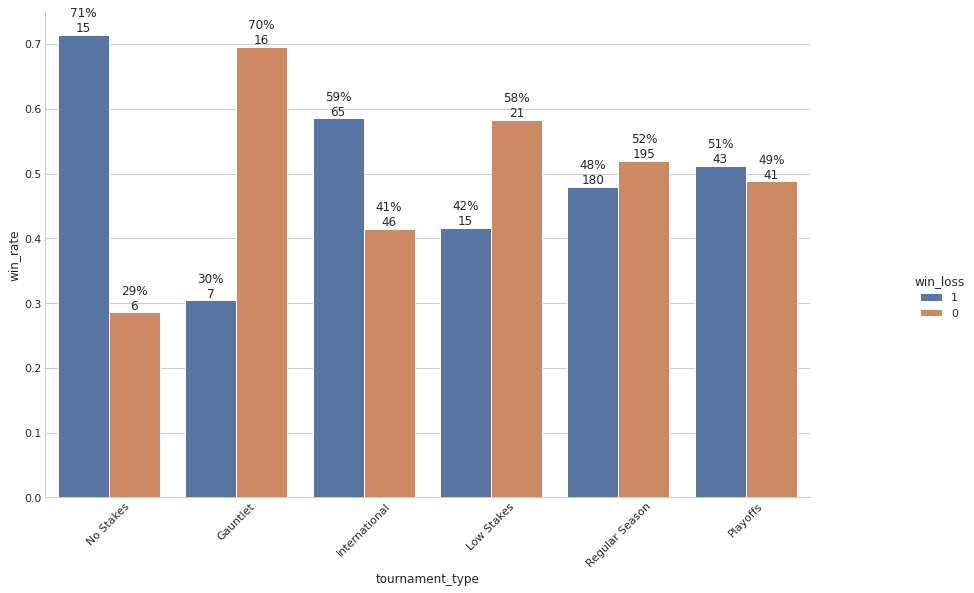

In [288]:
# TODO: fix total games number that is on top of each bar. utilize v.get_height * num of games
foo = data_target_encoded.groupby("tournament_type")['W/L'].value_counts(normalize=True)
# foo = copy.groupby("teammate_role_mid")['W/L'].value_counts(normalize=True).unstack(fill_value=0)
frame = {}
tournament_type, win_loss, rate = [], [], []
for r, test in foo.iteritems():
    tournament_type.append(r[0])
    win_loss.append(r[1])
    rate.append(test)

result = pd.DataFrame()
result['tournament_type'] = tournament_type
result['win_loss'] = win_loss
result['win_rate'] = rate
result = result.sort_values(['win_rate', 'win_loss'], ascending=False)

cnt = data_target_encoded['tournament_type'].value_counts()
# lst = []
# for region in result['region'].iteritems():
#     if region not in lst:
#         cnt = data_target_encoded['tournament_type'].value_counts()
#         lst.append

catp = sns.catplot(x="tournament_type", y="win_rate", hue="win_loss", data=result, kind="bar", hue_order=[1, 0])
plt.xticks(rotation=45)
catp.fig.set_size_inches(15, 8)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = catp.facet_axis(0, 0)
# iterate through the axes containers

i = 0
for c in ax.containers:
    labels = []
    for i, v in enumerate(c):
        perc = f"{v.get_height() * 100:.0f}"
        tournament_type = result.iloc[i].tournament_type
        total_games = f"{cnt.get(key=tournament_type)}"
        num_games = int(total_games) * float(v.get_height())

        top_of_bar = f"{perc}%\n{num_games:.0f}"
        labels.append(top_of_bar)
    # labels = [f'{(v.get_height()) * 100:.0f}%\n{cnt.iloc[i]}' for v,i in enumerate(c)]
    ax.bar_label(c, labels=labels, label_type='edge')

In [294]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np
X = data.copy()
# X = X[['Champion', 'teams_region', 'Vs_Team', 'tournament_type']]
Y = data_target_encoded['W/L']
feat_names = X.columns
rf = RandomForestRegressor()
rf.fit(X, Y)
print("Features sorted by their score:")
# print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feat_names), 
#              reverse=True))
woo = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feat_names), 
             reverse=True)
for tup in woo:
    print(f"{tup[1]}: {tup[0]}")

Features sorted by their score:
Champion: 0.0704
Spells: 0.0701
opponent_top_champion: 0.0603
opponent_mid_champion: 0.0555
teammate_top_champion: 0.0531
Vs_Team: 0.0399
teammate_support_champion: 0.0391
opponent_mid_ign: 0.0379
opponent_support_champion: 0.0337
teammate_jungle_champion: 0.0329
teammate_adc_champion: 0.032
opponent_adc_ign: 0.0312
opponent_support_ign: 0.0287
opponent_jungle_champion: 0.0286
opponent_adc_champion: 0.0255
enemy_role_top: 0.0229
opponent_jungle_ign: 0.0225
tournament_curr_total_games: 0.0224
tournament_curr_win_percentage: 0.0211
tournament_curr_wins: 0.0189
teammate_jungle_ign: 0.0183
teammate_role_jungle: 0.0175
teammate_role_top: 0.0173
opponent_top_ign: 0.0171
enemy_role_mid: 0.0169
tournaments_played: 0.0168
tournament_curr_losses: 0.0154
enemy_role_jungle: 0.0145
spell_1: 0.0133
teammate_role_mid: 0.0131
teammate_role_support: 0.0124
enemy_role_support: 0.0123
enemy_role_adc: 0.0114
teammate_top_ign: 0.0107
teammate_role_adc: 0.0099
teams_region_en

In [290]:
# # Ideal last step
# Choose which columns to keep
cols_for_model = []
model_ready = data[cols_for_model]
# data.to_csv("model_ready.csv")